<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Activity-Recognition/blob/Defense/Classification_CCA_Fusion(Sens%2BDMM_Sobel).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00


In [3]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
from statsmodels.multivariate.cancorr import CanCorr

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.optim as optim
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate


import torchvision
import torchvision.transforms as transforms



import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold

import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

import scipy.io as sio
torch.autograd.set_detect_anomaly(True)


from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn
#stats_cca = CanCorr(Y_train, X_train)

# print(stats_cca.corr_test().summary())
# X_train_c = stats_cca.x_cancoef
# Y_train_c = stats_cca.y_cancoef

In [7]:
gdrive_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/alexnet_DMM_Sobel_train_test_set.mat"
sensor_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/sensor_train_test_set.mat"

In [8]:
dat1 = sio.loadmat(gdrive_path)
dat2 = sio.loadmat(sensor_path)

In [9]:
X_train1 = dat1['X_train']
X_test1 = dat1['X_test']
X_val1 = dat1['X_val']
X_train2 = dat2['X_train']
X_test2 = dat2['X_test']
X_val2 = dat2['X_val']

y_train = dat1['y_train'].ravel()
y_test = dat1['y_test'].ravel()
y_val = dat1['y_val'].ravel()

In [10]:
print(X_train1.shape, X_train2.shape)

(742, 4096) (742, 417)


In [11]:
def dim_red(X_train, X_test,X_val,n_components):
  pca = PCA(n_components)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  X_val = pca.transform(X_val)
  return X_train, X_test,X_val


def CCAFusion(train_X, train_Y, test_X, test_Y, val_X, val_Y):
    n,p = train_X.shape
    q   = train_Y.shape[1]
    n_components = min(n,p,q)
    
    sc1 = StandardScaler()
    train_X = sc1.fit_transform(train_X)
    test_X = sc1.transform(test_X)
    val_X = sc1.transform(val_X)
    
    sc2 = StandardScaler()
    train_Y = sc2.fit_transform(train_Y)
    test_Y = sc2.transform(test_Y)
    val_Y = sc2.transform(val_Y)

    if(min(n,p,q) == n):
      train_Y, test_Y, val_Y = dim_red(train_Y, test_Y, val_Y, n_components)
      train_X, test_X, val_X = dim_red(train_X, test_X, val_X, n_components)
    elif(p<q):
      train_Y, test_Y, val_Y = dim_red(train_Y, test_Y, val_Y, n_components)
    elif(q<p):
      train_X, test_X, val_X = dim_red(train_X, test_X, val_X, n_components)
    
    ca = CCA(n_components)
    ca.fit(train_X, train_Y)
    train_X, train_Y = ca.transform(train_X, train_Y)
    test_X, test_Y = ca.transform(test_X, test_Y)
    val_X, val_Y = ca.transform(val_X, val_Y)
    return np.concatenate((train_X,train_Y), axis= 1), np.concatenate((test_X,test_Y), axis= 1), np.concatenate((val_X,val_Y), axis= 1),train_X+train_Y,test_X+test_Y,val_X+val_Y

In [12]:
start = time.time()
X_train_c,X_test_c,X_val_c, X_train_s,X_test_s,X_val_s = CCAFusion(X_train1, X_train2, X_test1, X_test2, X_val1, X_val2)
end = time.time()
print(f"It took {end-start} seconds to CCA Fuse.")

It took 288.60650086402893 seconds to CCA Fuse.


In [13]:
print(X_train_c.shape,X_test_c.shape,X_val_c.shape,X_train_s.shape,X_test_s.shape,X_val_s.shape)

(742, 834) (291, 834) (131, 834) (742, 417) (291, 417) (131, 417)


In [14]:
def train_test_loader(X_train, X_test, y_train, y_test):
  scaler = StandardScaler()
  train_X = X_train.copy()
  test_X = X_test.copy()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_dataset = TensorDataset(Tensor(train_X), Tensor(y_train))
  test_dataset = TensorDataset(Tensor(test_X), Tensor(y_test))
  test_loader = DataLoader(test_dataset, batch_size= 64)
  return train_dataset, test_loader

In [15]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,256)
        self.hidden2 = nn.Linear(256,128)
        self.hidden3 = nn.Linear(128,64)
        self.output = nn.Linear(64,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [16]:
def net_train(net, train_loader, parameters):
  criterion = nn.CrossEntropyLoss(reduction = "sum")
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )

  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )

  num_epochs = parameters.get("max_epoch", 3) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
    for inputs, labels in train_loader:
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels.long())
      loss.backward()
      optimizer.step()
      scheduler.step()
  return net

In [17]:
def train_evaluate(parameterization):
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_set,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True,drop_last=True)
    
    # Get neural net
    untrained_net = DNN(inpsize,outsize)
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization)
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=test_loader,
        dtype = torch.float,
        device = "cpu"
    )

In [36]:
train_set, test_loader = train_test_loader(X_train_c, X_val_c, y_train, y_val)
inpsize = X_train_c.shape[1]
outsize = np.unique(y_train).shape[0]
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-3, 0.2], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [20, 100]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},    
        {"name": "max_epoch", "type": "range", "bounds": [10, 100]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},     
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 02-08 19:25:03] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 19:25:03] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 19:25:03] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 19:25:03] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

{'lr': 0.0035803130135132516, 'batchsize': 49, 'momentum': 0.5093581066672337, 'max_epoch': 54, 'stepsize': 32}
{'accuracy': 0.9541984732824428}
{'accuracy': {'accuracy': nan}}


In [37]:
best_parameters

{'lr': 0.0035803130135132516,
 'batchsize': 49,
 'momentum': 0.5093581066672337,
 'max_epoch': 54,
 'stepsize': 32}

In [38]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

In [39]:
data = experiment.fetch_data()
dff = data.df
best_arm_name = dff.arm_name[dff['mean'] == dff['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='10_0', parameters={'lr': 0.0035803130135132516, 'batchsize': 49, 'momentum': 0.5093581066672337, 'max_epoch': 54, 'stepsize': 32})

In [40]:
def optim_scheduler(net,parameters):
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )
  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )
  return optimizer, scheduler
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]

def model_training_evaluation(X_train, X_test, y_train, y_test):
  train_X = X_train
  test_X = X_test
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_X = torch.from_numpy(train_X.astype(np.float32))
  test_X = torch.from_numpy(test_X.astype(np.float32))
  train_y =  torch.tensor(y_train.astype(np.float32))
  test_y =  torch.tensor(y_test.astype(np.float32))
  input_size = train_X.shape[1]
  output_size = torch.unique(train_y).shape[0]
  learning_rate = best_parameters['lr']
  num_epochs = best_parameters['max_epoch']
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
  net = DNN(input_size, output_size)
  optimizer, scheduler = optim_scheduler(net,best_parameters)
  figure, ax = plt.subplots(5,figsize=(10,10))
  figure.tight_layout(pad=5.0)
  cnt = 1
  best_loss = 100000
  best_model = None
  best_epoch = None
  for train_index, val_index in skf.split(X_train, y_train):
    train_X_fold = train_X[train_index]
    train_y_fold = train_y[train_index]
    val_x_fold = train_X[val_index]
    val_y_fold = train_y[val_index]
    n_samples = train_X_fold.shape[0]
    batch_size = best_parameters['batchsize']
    train_loss = []
    val_loss = []
    print(f"Training for fold {cnt}")
    for epoch in range(num_epochs):
      step = 1
      while(batch_size*step<=n_samples):
        x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
        # Forward Propagation
        y_predicted = net(x)
        loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
        # Backward propagation and update
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Performing zero grad before new step
        optimizer.zero_grad()
        step = step+1
      t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
      v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
      train_loss.append(t_loss) 
      val_loss.append(v_loss)
      if(v_loss<best_loss):
        best_loss = v_loss
        best_model = net
        best_epoch = epoch
      print(epoch*100/num_epochs)
    m = "Fold "+str(cnt)
    ax[cnt-1].title.set_text(m)
    ax[cnt-1].set_ylabel("Total Loss")
    ax[cnt-1].set_xlabel("No of Epochs")
    ax[cnt-1].plot(range(num_epochs),train_loss, label = "train loss")
    ax[cnt-1].plot(range(num_epochs),val_loss, label = "validation loss")
    cnt+=1
  y_pred = best_model(test_X)
  return best_model, y_pred


Training for fold 1
0.0
1.8518518518518519
3.7037037037037037
5.555555555555555
7.407407407407407
9.25925925925926
11.11111111111111
12.962962962962964
14.814814814814815
16.666666666666668
18.51851851851852
20.37037037037037
22.22222222222222
24.074074074074073
25.925925925925927
27.77777777777778
29.62962962962963
31.48148148148148
33.333333333333336
35.18518518518518
37.03703703703704
38.888888888888886
40.74074074074074
42.592592592592595
44.44444444444444
46.2962962962963
48.148148148148145
50.0
51.851851851851855
53.7037037037037
55.55555555555556
57.407407407407405
59.25925925925926
61.111111111111114
62.96296296296296
64.81481481481481
66.66666666666667
68.51851851851852
70.37037037037037
72.22222222222223
74.07407407407408
75.92592592592592
77.77777777777777
79.62962962962963
81.48148148148148
83.33333333333333
85.18518518518519
87.03703703703704
88.88888888888889
90.74074074074075
92.5925925925926
94.44444444444444
96.29629629629629
98.14814814814815
Training for fold 2
0.0
1

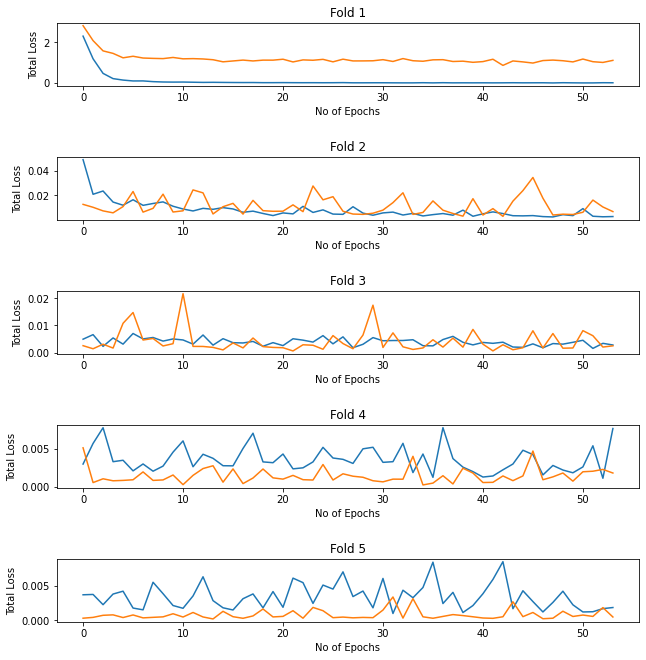

In [41]:
start = time.time()
best_model, y_pred = model_training_evaluation(X_train_c, X_test_c, y_train, y_test)
end = time.time()
training_time = end - start

In [42]:
print(f"Time took to train {training_time} seconds")

Time took to train 58.75471115112305 seconds


In [43]:
def cf_matrix(y_pred, test_y):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)
  y_pred = y_pred.detach().numpy().ravel()
  correct_pred = (y_pred == test_y).astype(np.float)
  acc = correct_pred.sum()*100.0 / y_pred.shape[0]
  cm = confusion_matrix(test_y.ravel(), y_pred)
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f1 = 2*((precision*recall*1.0)/(precision+recall))
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  print(f"Accuracy: {acc:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Recall: {recall:.2f}%")
  print(f"F1 score: {f1:.2f}%")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm,acc, recall, precision, f1


Accuracy: 94.50%
Precision: 94.85%
Recall: 94.53%
F1 score: 94.69%


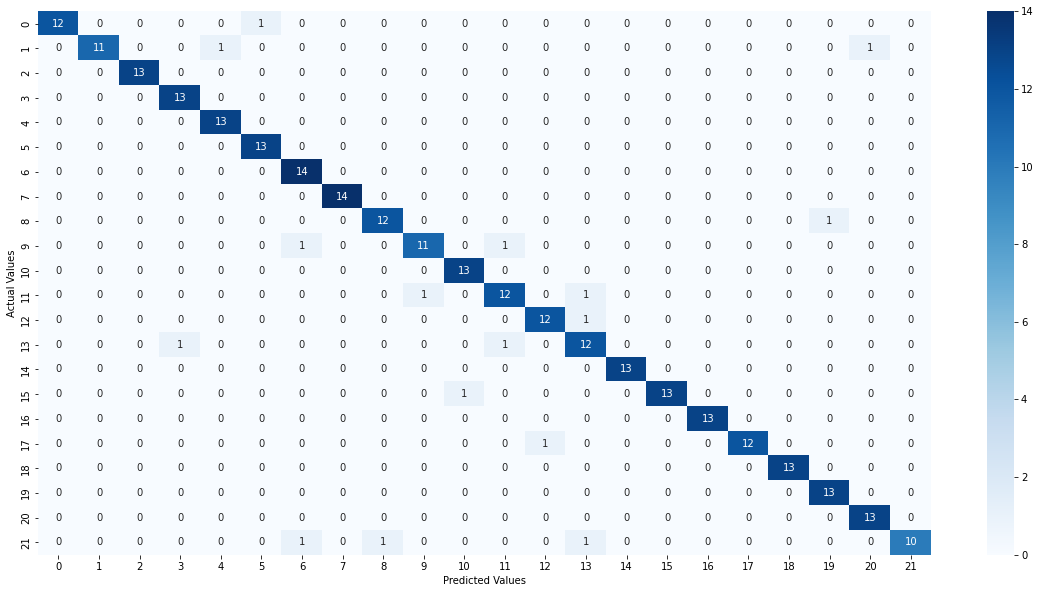

In [44]:
cm,acc, recall, precision,f1 = cf_matrix(y_pred, y_test)

In [27]:
pred_dict = {"preds":y_pred.detach().numpy(), 'y_test':y_test.ravel()}
sio.savemat("drive/My Drive/Dataset/Final Dataset/Predictions/FF_CCA(sens+DMM_Sobel, concat)_predictions.mat", pred_dict)

In [28]:
import datetime
ts = str((datetime.datetime.now()).timestamp())
model_save_name = 'FF_CCA(sens+DMM_Sobel, concat)_DNN_'+ts+'_.pt'
path = F"drive/My Drive/Dataset/Final Dataset/Models/Feature Fusion/{model_save_name}" 
torch.save(best_model.state_dict(), path)

In [29]:
train_set, test_loader = train_test_loader(X_train_s, X_val_s, y_train, y_val)
inpsize = X_train_s.shape[1]
outsize = np.unique(y_train).shape[0]
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.2], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [20, 100]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},    
        {"name": "max_epoch", "type": "range", "bounds": [10, 100]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},     
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 02-08 19:04:58] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 19:04:58] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 19:04:58] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 19:04:58] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

{'lr': 0.03180743154594527, 'batchsize': 77, 'momentum': 0.4041290814164829, 'max_epoch': 89, 'stepsize': 27}
{'accuracy': 0.880203080274456}
{'accuracy': {'accuracy': 0.0025107611819519104}}


In [30]:
best_parameters

{'lr': 0.03180743154594527,
 'batchsize': 77,
 'momentum': 0.4041290814164829,
 'max_epoch': 89,
 'stepsize': 27}

In [31]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

Training for fold 1
0.0
1.1235955056179776
2.247191011235955
3.3707865168539324
4.49438202247191
5.617977528089888
6.741573033707865
7.865168539325842
8.98876404494382
10.112359550561798
11.235955056179776
12.359550561797754
13.48314606741573
14.606741573033707
15.730337078651685
16.853932584269664
17.97752808988764
19.10112359550562
20.224719101123597
21.348314606741575
22.471910112359552
23.59550561797753
24.719101123595507
25.84269662921348
26.96629213483146
28.089887640449437
29.213483146067414
30.337078651685392
31.46067415730337
32.58426966292135
33.70786516853933
34.831460674157306
35.95505617977528
37.07865168539326
38.20224719101124
39.325842696629216
40.449438202247194
41.57303370786517
42.69662921348315
43.82022471910113
44.943820224719104
46.06741573033708
47.19101123595506
48.31460674157304
49.438202247191015
50.561797752808985
51.68539325842696
52.80898876404494
53.93258426966292
55.056179775280896
56.17977528089887
57.30337078651685
58.42696629213483
59.550561797752806
6

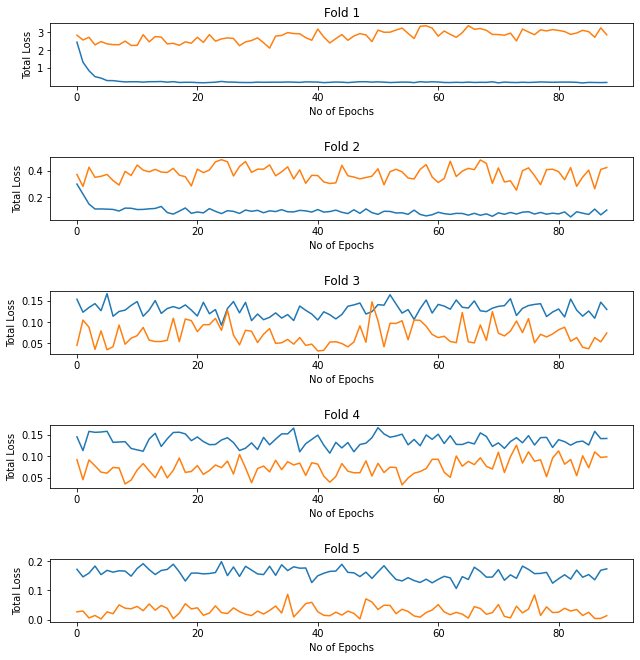

In [32]:
start = time.time()
best_model, y_pred = model_training_evaluation(X_train_s, X_test_s, y_train, y_test)
end = time.time()
training_time = end - start

In [33]:
print(f"Time took to train {training_time} seconds")

Time took to train 57.414814472198486 seconds


Accuracy: 88.66%
Precision: 89.88%
Recall: 88.59%
F1 score: 89.23%


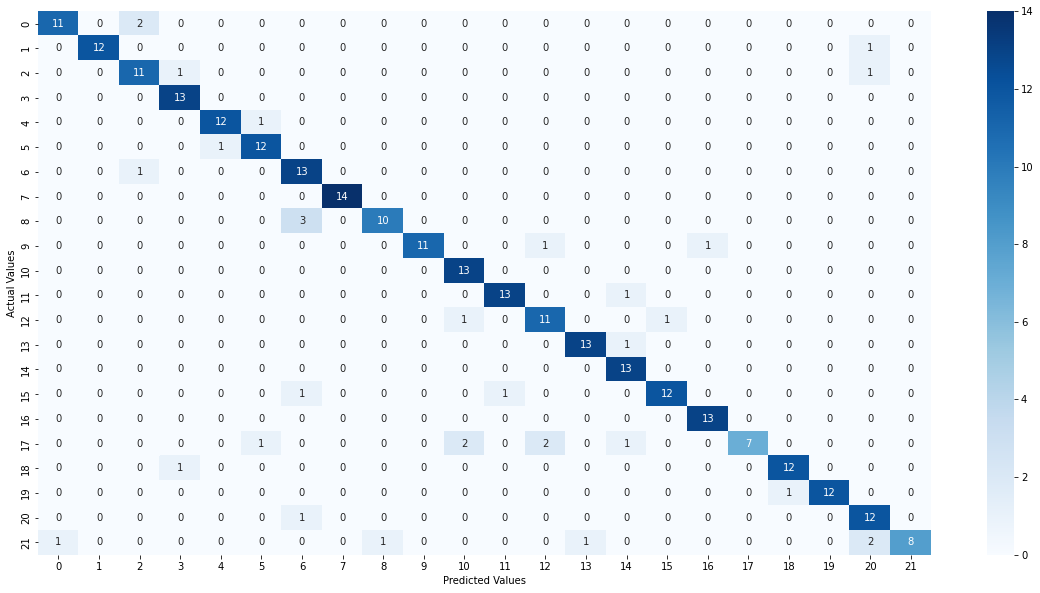

In [34]:
cm,acc, recall, precision,f1 = cf_matrix(y_pred, y_test)

In [35]:
pred_dict = {"preds":y_pred.detach().numpy(), 'y_test':y_test.ravel()}
sio.savemat("drive/My Drive/Dataset/Final Dataset/Predictions/FF_CCA(sens+DMM_Sobel, sum)_predictions.mat", pred_dict)

ts = str((datetime.datetime.now()).timestamp())
model_save_name = 'FF_CCA(sens+DMM_Sobel, sum)_DNN_'+ts+'_.pt'
path = F"drive/My Drive/Dataset/Final Dataset/Models/Feature Fusion/{model_save_name}" 
torch.save(best_model.state_dict(), path)